In [23]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## Load the data

In [24]:
# Load the qwen.jsonl file
data = []
with open('ml/evaluator/batch_results/qwen.jsonl', 'r') as f:
    for line in f:
        data.append(json.loads(line))

print(f"Loaded {len(data)} records")

Loaded 100 records


## Extract relevant information

In [25]:
# Extract message content and calculate length
records = []
for item in data:
    # Get the assistant's message content
    if 'responses' in item and 'content' in item['responses']:
        message = item['responses']['content']
    elif 'messages' in item:
        # Find the last assistant message
        assistant_messages = [m for m in item['messages'] if m.get('role') == 'assistant']
        if assistant_messages:
            message = assistant_messages[-1].get('content', '')
        else:
            continue
    else:
        continue
    
    # Calculate message length
    message_length = len(message)
    
    # Extract scores if available
    # We need to look for R, S, D scores in the data
    # They might be in different fields, let's explore
    record = {
        'message_length': message_length,
        'message': message,
    }
    
    # Check for score fields
    for key in ['R', 'S', 'D', 'r_score', 's_score', 'd_score', 'relevance', 'similarity', 'diversity']:
        if key in item:
            record[key] = item[key]
    
    records.append(record)

df = pd.DataFrame(records)
print(f"Created DataFrame with {len(df)} records")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Created DataFrame with 100 records

Columns: ['message_length', 'message']

First few rows:


,message_length,message
0,1770,"<think>\nOkay, the user wants a color palette ..."
1,2195,"<think>\nOkay, the user wants a color palette ..."
2,2360,"<think>\nOkay, the user is asking for a color ..."
3,2572,"<think>\nOkay, the user is asking for a color ..."
4,2539,"<think>\nOkay, let's tackle this query. The us..."


## Explore the data structure to find scores

In [26]:
# Let's look at a sample item to understand the structure
print("Sample item keys:")
print(json.dumps(list(data[0].keys()), indent=2))
print("\nSample item:")
print(json.dumps(data[0], indent=2)[:1000] + "...")

Sample item keys:
[
  "messages",
  "rollout_status",
  "gt_palette",
  "gt_diversity",
  "original_messages",
  "responses",
  "request_id",
  "usage"
]

Sample item:
{
  "messages": [
    {
      "role": "system",
      "content": "\nYou are an expert Color Theorist and UI Designer. Your task is to generate a cohesive, aesthetically pleasing color palette based on a user's text query.\n\nGenerate a JSON response with the following format:\n{\n    \"palette_text\": [\"color_name1\", \"color_name2\", \"color_name3\", \"color_name4\", \"color_name5\"],\n    \"palette_hex\": [\"(H, S%, L%)\", \"(H, S%, L%)\", \"(H, S%, L%)\", \"(H, S%, L%)\", \"(H, S%, L%)\"]\n}\nwhere H is between [0, 360), and S and L are between [0, 100]. No decimals.\nAs a reminder, H stands for hue, S stands for saturation, and L stands for lightness\n"
    },
    {
      "role": "user",
      "content": "\nWhat's the best color palette consisting of five colors to describe the text \"sedulity\"?\nProvide the color 

## Check for score files or calculate scores
If scores aren't in the JSONL file, we may need to load them from a separate file or calculate them.

In [27]:
# Check if there are any CSV files with scores
results_dir = Path('ml/evaluator/results')
csv_files = list(results_dir.glob('*.csv'))
print(f"Found {len(csv_files)} CSV files in results directory:")
for f in csv_files[:5]:
    print(f"  - {f.name}")

Found 17 CSV files in results directory:
  - eval_fireworks_accounts_sidvenkatayogi_models_artist-v2_20260109_201255.csv
  - eval_fireworks_accounts_sidvenkatayogi_models_artist-qwen3-8b-5-5-8_20260109_195746.csv
  - eval_fireworks_accounts_sidvenkatayogi_models_artist-qwen2p5-vl-7b-instruct_20260109_195632.csv
  - eval_openai_gpt-5-mini_20260103_021759.csv
  - eval_fireworks_accounts_fireworks_models_llama-v3p3-70b-instruct_20260103_021738.csv


In [28]:
import re
import sys
sys.path.insert(0, '/Users/sidvenkatayogi/Documents/Code/chromio')
from ml.grader.evaluation import ColorPalette, DccwMeasurer, normalize_inv_map, harmonic_mean

def extract_hsl_from_string(content: str) -> list:
    """Extract HSL colors from string using regex."""
    hsl_pattern = r'\(\s*(\d{1,3})\s*,\s*(\d{1,3})%\s*,\s*(\d{1,3})%\s*\)'
    matches = re.findall(hsl_pattern, content)
    
    hsl_colors = []
    for h, s, l in matches:
        h_int, s_int, l_int = int(h), int(s), int(l)
        if 0 <= h_int < 360 and 0 <= s_int <= 100 and 0 <= l_int <= 100:
            hsl_colors.append(f"({h_int}, {s_int}%, {l_int}%)")
        if len(hsl_colors) >= 5:
            break
    return hsl_colors

def hsl_to_hex(hsl_str: str) -> str:
    """Convert HSL string format "(H, S%, L%)" to hex color."""
    match = re.match(r'\(\s*(\d{1,3})\s*,\s*(\d{1,3})%\s*,\s*(\d{1,3})%\s*\)', hsl_str)
    if not match:
        return "#000000"
    
    h, s, l = int(match.group(1)), int(match.group(2)), int(match.group(3))
    h, s, l = h / 360.0, s / 100.0, l / 100.0
    
    def hue_to_rgb(p, q, t):
        if t < 0: t += 1
        if t > 1: t -= 1
        if t < 1/6: return p + (q - p) * 6 * t
        if t < 1/2: return q
        if t < 2/3: return p + (q - p) * (2/3 - t) * 6
        return p
    
    if s == 0:
        r = g = b = l
    else:
        q = l * (1 + s) if l < 0.5 else l + s - l * s
        p = 2 * l - q
        r = hue_to_rgb(p, q, h + 1/3)
        g = hue_to_rgb(p, q, h)
        b = hue_to_rgb(p, q, h - 1/3)
    
    return f"#{int(round(r*255)):02x}{int(round(g*255)):02x}{int(round(b*255)):02x}"

# Calculate R, S, D scores for each record
print("Calculating R, S, D scores from HSL palettes...")
for record in records:
    try:
        # Get the assistant's message
        message = record['message']
        
        # Extract HSL colors from the response
        hsl_colors = extract_hsl_from_string(message)
        
        # Convert to hex
        generated_hex = [hsl_to_hex(hsl) for hsl in hsl_colors[:5]]
        
        # Pad if needed
        if len(generated_hex) < 5:
            generated_hex = generated_hex + ['#000000'] * (5 - len(generated_hex))
        
        # Find ground truth palette from original data item
        # We need to match the record back to the original data
        item_idx = records.index(record)
        gt_palette = data[item_idx].get('gt_palette', [])
        
        # Convert ground truth HSL to hex if needed
        if gt_palette and isinstance(gt_palette[0], str) and '(' in gt_palette[0]:
            gt_hex = [hsl_to_hex(hsl) for hsl in gt_palette]
        else:
            # If not available, skip scoring
            record['R'] = float('nan')
            record['S'] = float('nan')
            record['D'] = float('nan')
            continue
        
        # Calculate metrics using DccwMeasurer
        dccw_measurer = DccwMeasurer(
            source=generated_hex,
            source_option='hex',
            target=gt_hex,
            target_option='hex'
        )
        
        dccw_score_no_cycle = dccw_measurer.measure_dccw(reflect_cycle=False)
        source_diversity = dccw_measurer.calculate_source_diversity()
        target_diversity = dccw_measurer.calculate_target_diversity()
        
        # Calculate normalized scores
        norm_D = normalize_inv_map(abs(target_diversity - source_diversity), tau=15.0, k=0.2)
        norm_S = normalize_inv_map(dccw_score_no_cycle, tau=26.0, k=0.15)
        score_R = harmonic_mean(norm_D, norm_S)
        
        # Store scores
        record['R'] = score_R
        record['S'] = norm_S
        record['D'] = norm_D
        record['gt_diversity'] = target_diversity
        record['gen_diversity'] = source_diversity
        record['raw_dccw'] = dccw_score_no_cycle
        
    except Exception as e:
        print(f"Error processing record {records.index(record)}: {e}")
        record['R'] = float('nan')
        record['S'] = float('nan')
        record['D'] = float('nan')

# Recreate DataFrame with scores
df = pd.DataFrame(records)
print(f"\nDataFrame with calculated scores:")
print(f"Columns: {df.columns.tolist()}")
print(f"\nScore statistics:")
df[['message_length', 'R', 'S', 'D']].describe()

/Users/sidvenkatayogi/Documents/Code/chromio/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Calculating R, S, D scores from HSL palettes...


/Users/sidvenkatayogi/Documents/Code/chromio/ml/grader/evaluation.py:574: RuntimeWarning: invalid value encountered in scalar divide
  t = max(0, min(np.dot(v, n)/np.dot(n, n), 1))



DataFrame with calculated scores:
Columns: ['message_length', 'message', 'R', 'S', 'D', 'gt_diversity', 'gen_diversity', 'raw_dccw']

Score statistics:


,message_length,R,S,D
count,100.000000,100.000000,100.000000,100.000000
mean,4768.390000,0.467506,0.487815,0.600470
std,1455.601774,0.288656,0.291138,0.318131
min,1770.000000,0.004828,0.008823,0.002900
25%,3535.250000,0.180953,0.231593,0.298051
50%,4915.500000,0.452408,0.500865,0.714654
75%,6147.750000,0.731924,0.755759,0.886438
max,7741.000000,0.924744,0.954395,0.947277


## Visualize: Message Length vs R, S, D Scores

**Score Definitions:**
- **R Score**: Overall quality score (harmonic mean of S and D)
- **S Score**: Similarity score (how close generated palette is to ground truth)
- **D Score**: Diversity score (how similar the diversity of generated palette is to ground truth)

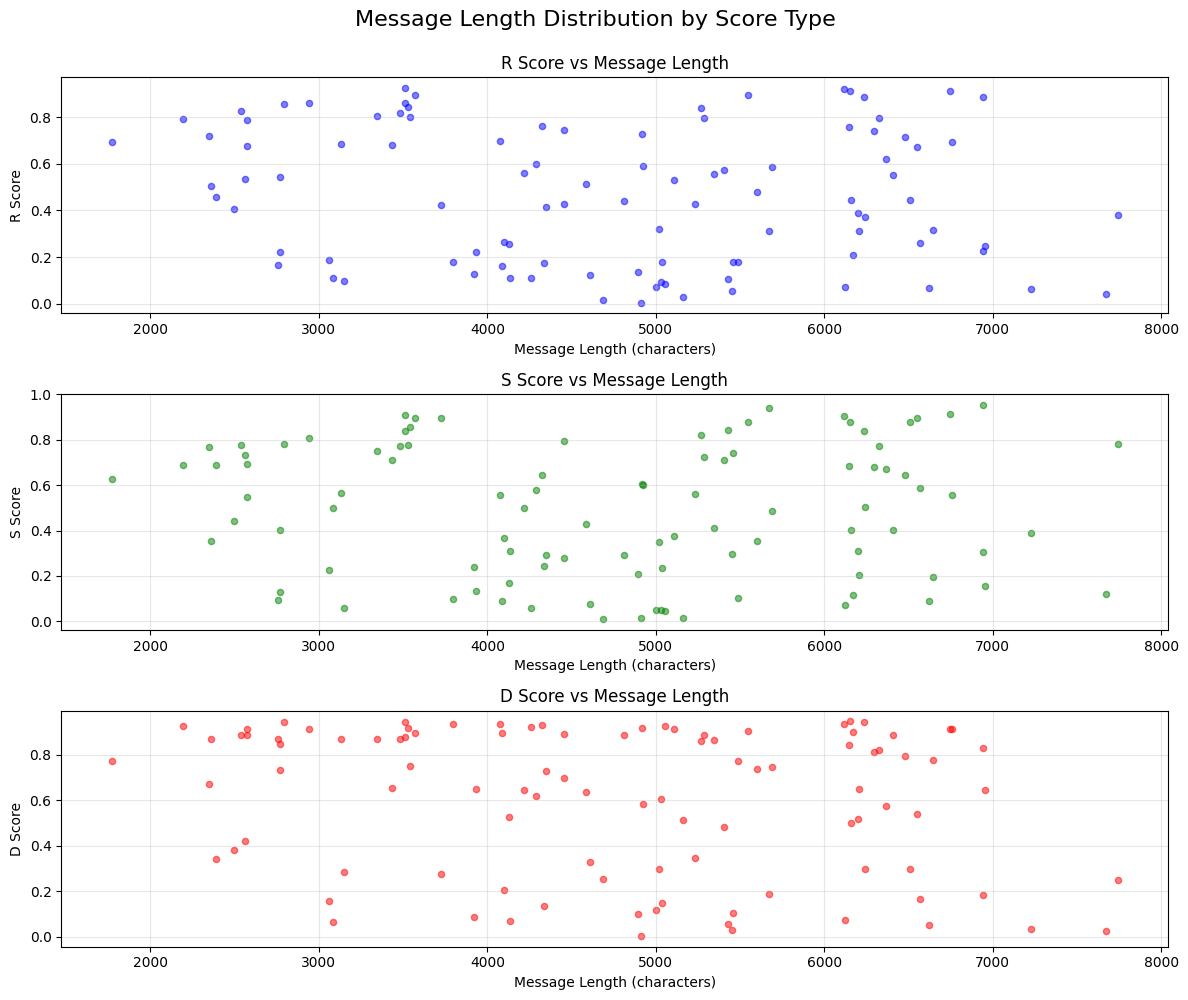

In [ ]:
# Create figure with 3 subplots for R, S, D scores
fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('Score vs Message Length', fontsize=16, y=0.995)

# Plot for R score
axes[0].scatter(df['message_length'], df['R'], alpha=0.6, c='blue', s=30, edgecolors='navy', linewidth=0.5)
axes[0].set_xlabel('Message Length (characters)', fontsize=11)
axes[0].set_ylabel('R Score (Overall Quality)', fontsize=11)
axes[0].set_title('R Score vs Message Length', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.05, 1.05)

# Plot for S score
axes[1].scatter(df['message_length'], df['S'], alpha=0.6, c='green', s=30, edgecolors='darkgreen', linewidth=0.5)
axes[1].set_xlabel('Message Length (characters)', fontsize=11)
axes[1].set_ylabel('S Score (Similarity)', fontsize=11)
axes[1].set_title('S Score vs Message Length', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.05, 1.05)

# Plot for D score
axes[2].scatter(df['message_length'], df['D'], alpha=0.6, c='red', s=30, edgecolors='darkred', linewidth=0.5)
axes[2].set_xlabel('Message Length (characters)', fontsize=11)
axes[2].set_ylabel('D Score (Diversity)', fontsize=11)
axes[2].set_title('D Score vs Message Length', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

## Combined visualization: All scores on one plot

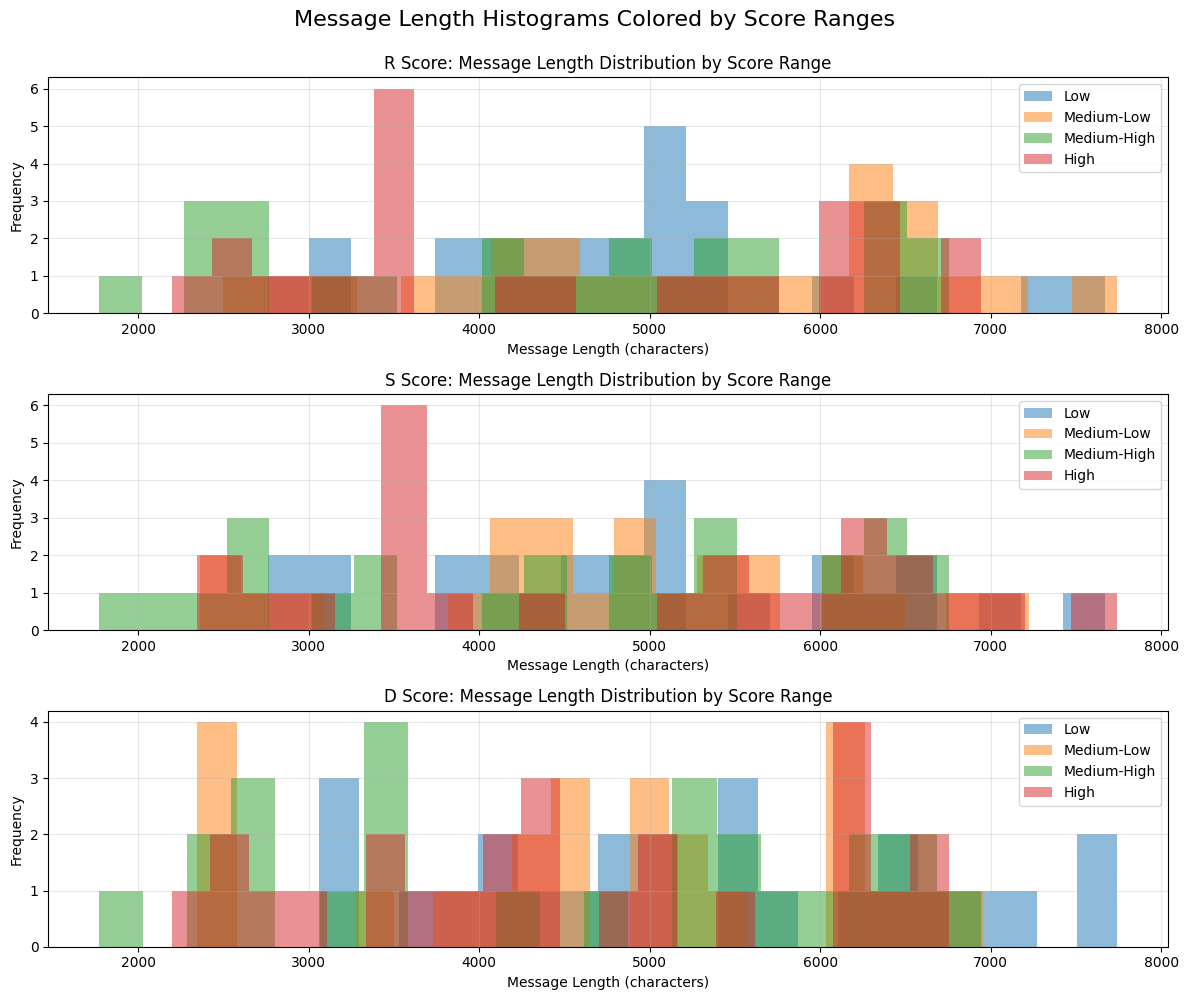

In [ ]:
# Create a single plot with all three scores
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

ax.scatter(df['message_length'], df['R'], alpha=0.6, c='blue', s=40, label='R Score (Overall)', edgecolors='navy', linewidth=0.5)
ax.scatter(df['message_length'], df['S'], alpha=0.6, c='green', s=40, label='S Score (Similarity)', edgecolors='darkgreen', linewidth=0.5)
ax.scatter(df['message_length'], df['D'], alpha=0.6, c='red', s=40, label='D Score (Diversity)', edgecolors='darkred', linewidth=0.5)

ax.set_xlabel('Message Length (characters)', fontsize=13)
ax.set_ylabel('Score', fontsize=13)
ax.set_title('All Scores vs Message Length', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.05, 1.05)

plt.tight_layout()
plt.show()

## Correlation analysis

Correlation matrix:
                message_length         R         S         D
message_length        1.000000 -0.146662 -0.036678 -0.205636
R                    -0.146662  1.000000  0.819890  0.704858
S                    -0.036678  0.819890  1.000000  0.301208
D                    -0.205636  0.704858  0.301208  1.000000


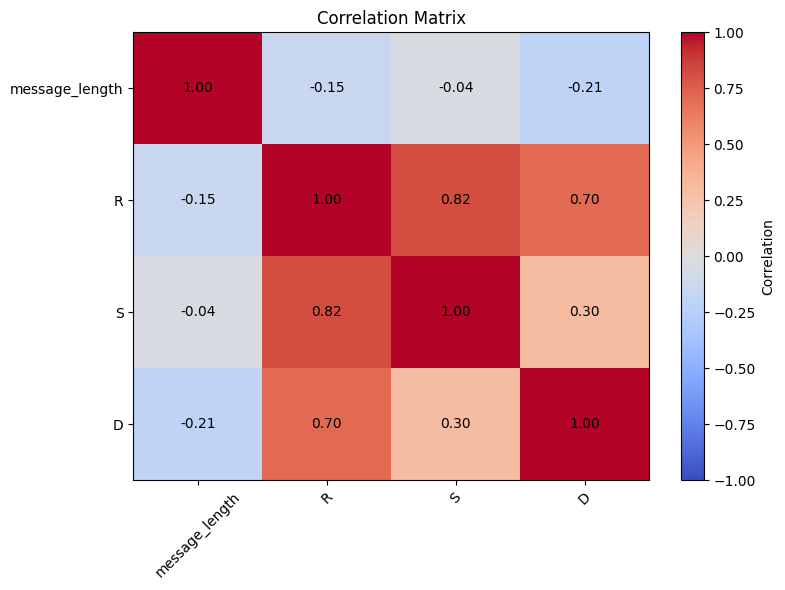

In [31]:
# Calculate correlations
correlations = df[['message_length', 'R', 'S', 'D']].corr()
print("Correlation matrix:")
print(correlations)

# Visualize correlation
plt.figure(figsize=(8, 6))
plt.imshow(correlations, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=45)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.title('Correlation Matrix')

# Add correlation values as text
for i in range(len(correlations.columns)):
    for j in range(len(correlations.columns)):
        plt.text(j, i, f'{correlations.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

## Summary statistics

In [32]:
# Summary statistics
print("Summary Statistics:")
print("="*50)
print(f"\nMessage Length:")
print(f"  Mean: {df['message_length'].mean():.2f}")
print(f"  Median: {df['message_length'].median():.2f}")
print(f"  Std Dev: {df['message_length'].std():.2f}")
print(f"  Min: {df['message_length'].min():.2f}")
print(f"  Max: {df['message_length'].max():.2f}")

for score in ['R', 'S', 'D']:
    print(f"\n{score} Score:")
    print(f"  Mean: {df[score].mean():.3f}")
    print(f"  Median: {df[score].median():.3f}")
    print(f"  Std Dev: {df[score].std():.3f}")
    print(f"  Correlation with message length: {df['message_length'].corr(df[score]):.3f}")

Summary Statistics:

Message Length:
  Mean: 4768.39
  Median: 4915.50
  Std Dev: 1455.60
  Min: 1770.00
  Max: 7741.00

R Score:
  Mean: 0.468
  Median: 0.452
  Std Dev: 0.289
  Correlation with message length: -0.147

S Score:
  Mean: 0.488
  Median: 0.501
  Std Dev: 0.291
  Correlation with message length: -0.037

D Score:
  Mean: 0.600
  Median: 0.715
  Std Dev: 0.318
  Correlation with message length: -0.206
